In [10]:
import matplotlib.pyplot as plt
import numpy as np

from superfv import OutputLoader, plot_2d_slice

In [11]:
def compute_M(idx, mesh, w, gamma, v0, t):
    x, y, _ = mesh.get_cell_centers()
    rho = w[idx("rho")]
    vx = w[idx("vx")] - v0
    vy = w[idx("vy")]
    P = w[idx("P")]

    x = (x - v0 * t) % 1
    xc = x - 0.5
    yc = y - 0.5
    r = np.sqrt(xc**2 + yc**2)

    v_phi = vx * (-yc / r) + vy * (xc / r)

    cs2 = gamma * P / rho
    cs = np.sqrt(np.maximum(cs2, 0.0))

    M = np.abs(v_phi) / cs

    return M


def compute_M_func(gamma, v0, t, M_max):
    def f(idx, mesh, w):
        M = compute_M(idx, mesh, w, gamma, v0, t)
        return M / M_max

    return f

In [12]:
# sim = OutputLoader("/scratch/gpfs/jp7427/out/gresho-vortex2/debug/v0_5.0/p7/M_max_0.001/")
sim = OutputLoader(
    "/scratch/gpfs/jp7427/out/gresho-vortex2/debug/v0_5.0/MM7/1rev/no_v/rtol_1e-2/no_kernel/M_max_0.001/"
)

Successfully read simulation output from "/scratch/gpfs/jp7427/out/gresho-vortex2/debug/v0_5.0/MM7/1rev/no_v/rtol_1e-2/no_kernel/M_max_0.001"


/home/jp7427/Desktop/superfv/superfv/visualization.py:43: UserWarning: Cell-centered coordinate 0.1 not exactly matched in mesh; using nearest: 0.100003
  warnings.warn(
/home/jp7427/Desktop/superfv/superfv/visualization.py:43: UserWarning: Cell-centered coordinate 0.1 not exactly matched in mesh; using nearest: 0.100003
  warnings.warn(
/home/jp7427/Desktop/superfv/superfv/visualization.py:43: UserWarning: Cell-centered coordinate 0.1 not exactly matched in mesh; using nearest: 0.100003
  warnings.warn(
/home/jp7427/Desktop/superfv/superfv/visualization.py:43: UserWarning: Cell-centered coordinate 0.1 not exactly matched in mesh; using nearest: 0.100003
  warnings.warn(
/home/jp7427/Desktop/superfv/superfv/visualization.py:43: UserWarning: Cell-centered coordinate 0.1 not exactly matched in mesh; using nearest: 0.100003
  warnings.warn(


(<matplotlib.image.AxesImage at 0x15328da6e630>,
 <matplotlib.colorbar.Colorbar at 0x15328dacd280>)

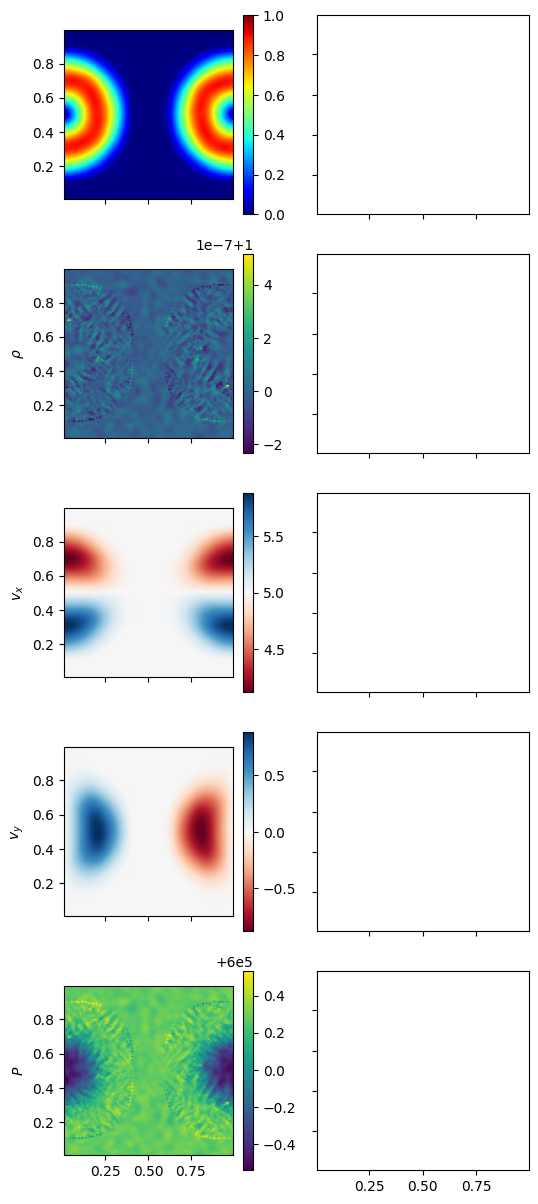

In [13]:
fig, axs = plt.subplots(5, 2, sharex=True, sharey=True, figsize=(6, 15))

axs[1, 0].set_ylabel(r"$\rho$")
axs[2, 0].set_ylabel(r"$v_x$")
axs[3, 0].set_ylabel(r"$v_y$")
axs[4, 0].set_ylabel(r"$P$")

t = 0.1

mach_style = dict(cell_averaged=True, colorbar=True, vmin=0, vmax=1, cmap="jet")
plot_2d_slice(
    sim,
    axs[0, 0],
    "w",
    multivar_func=compute_M_func(5 / 3, 5.0, t, 0.001),
    t=t,
    **mach_style,
)

style = dict(cell_averaged=True, colorbar=True)
plot_2d_slice(sim, axs[1, 0], "rho", t=t, **style)
plot_2d_slice(sim, axs[2, 0], "vx", t=t, cmap="RdBu", **style)
plot_2d_slice(sim, axs[3, 0], "vy", t=t, cmap="RdBu", **style)
plot_2d_slice(sim, axs[4, 0], "P", t=t, **style)

# theta_style=dict(troubles=True, visualization=False, colorbar=True, vmin=0, vmax=1, cmap="Reds")
# plot_2d_slice(sim, axs[1, 1], "rho", t=t, **theta_style)
# plot_2d_slice(sim, axs[2, 1], "vx", t=t, **theta_style)
# plot_2d_slice(sim, axs[3, 1], "vy", t=t, **theta_style)
# plot_2d_slice(sim, axs[4, 1], "P", t=t, **theta_style)

In [3]:
import pickle

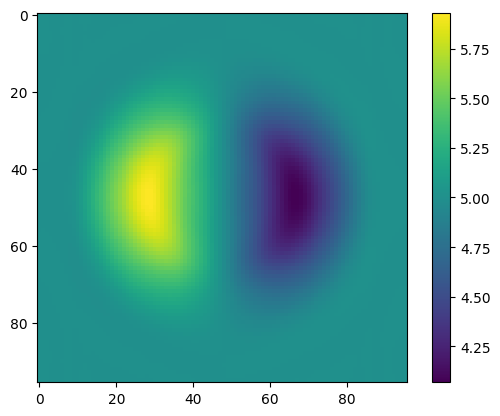

In [38]:
with open(
    "/scratch/gpfs/jp7427/out/gresho-vortex/v0_5.0/p3/M_max_0.001/snapshots/snapshot_0001.pkl",
    "rb",
) as pf:
    snapshot = pickle.load(pf)

plt.imshow(snapshot["w"][1])
plt.colorbar()

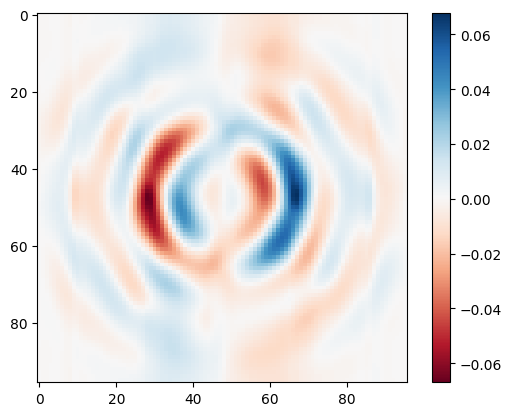

In [40]:
with open(
    "/scratch/gpfs/jp7427/out/gresho-vortex/v0_5.0/MM3/1rev/no_v/rtol_1e-2/M_max_0.001/snapshots/snapshot_0001.pkl",
    "rb",
) as pf:
    snapshot2 = pickle.load(pf)

# plt.imshow(snapshot2["w"][1])
plt.imshow(snapshot2["w"][1] - snapshot["w"][1], cmap="RdBu")
plt.colorbar()